In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import scipy.io as sio
from numpy import expand_dims
from numpy import asarray
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from skimage.filters import gabor_kernel
from scipy import ndimage as nd        
import matplotlib
import matplotlib.pyplot as plt    
from numpy.linalg import norm
from keras.optimizers import SGD, Adam
import graphviz
import pydot
from numpy import reshape
from sklearn.manifold import TSNE
import pandas as pd  
import seaborn as sns
import scipy.io

In [2]:

#Please add the folder name of the dataset to run it on different dataset.
dataset = 'AWA2'
path = 'E:/Sushree/Dataset/data/xlsa17/data/'

res101 = scipy.io.loadmat(path + dataset + '/res101.mat')
att_splits = scipy.io.loadmat(path + dataset + '/att_splits.mat')

In [3]:

# total number of instances or images = 37322: ranges from 0 to 37321


labels = res101['labels']# direct class labels
print('labels', labels, labels.shape)# 37322 x 1

print('unique_labels', np.unique(labels), np.unique(labels).shape)# class labels range from 1 to 50, 50 classes

X_features = res101['features']


labels [[ 1]
 [ 1]
 [ 1]
 ...
 [38]
 [38]
 [38]] (37322, 1)
unique_labels [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] (50,)


[    2     4     5 ... 37318 37320 37321] 37321
labels_trainval [[43]
 [22]
 [43]
 ...
 [40]
 [19]
 [46]] (23527, 1)
unique_labels_trainval [ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 17 18 19 20 21 22 25 26 27 28
 29 32 33 35 36 37 38 39 40 42 43 44 45 46 48 49] (40,)
Features for trainval: (23527, 2048)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23527 samples in 0.053s...
[t-SNE] Computed neighbors for 23527 samples in 6.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23527
[t-SNE] Computed conditional probabilities for sample 2000 / 23527
[t-SNE] Computed conditional probabilities for sample 3000 / 23527
[t-SNE] Computed conditional probabilities for sample 4000 / 23527
[t-SNE] Computed conditional probabilities for sample 5000 / 23527
[t-SNE] Computed conditional probabilities for sample 6000 / 23527
[t-SNE] Computed conditional probabilities for sample 7000 / 23527
[t-SNE] Computed conditional probabilities for sample 8000 / 23527
[t-SNE] Compute

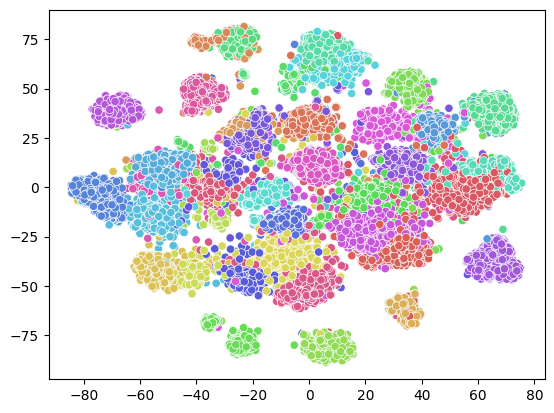

In [4]:

# get the labels for trainval, test seen and test unseen sets
trainval_loc = np.squeeze(att_splits['trainval_loc']-1) # -1: to consider the overflow problem
print(np.unique(trainval_loc), np.max(np.unique(trainval_loc))) # smallest location: 2, largest location 37321

labels_trainval = labels[trainval_loc]
print('labels_trainval', labels_trainval, labels_trainval.shape)

unique_labels_trainval = np.unique(labels_trainval) # labels min:1 max:49
print('unique_labels_trainval', unique_labels_trainval, unique_labels_trainval.shape)# 40 classes


# locations are already subtracted by 1, so they range from 0 to 37321
trainval_vec = X_features[:, trainval_loc].transpose()
print("Features for trainval:", trainval_vec.shape) #(23527, 2048)

num_classes = 40

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(trainval_vec) 

print(z.shape)

df = pd.DataFrame()
df["y"] = np.reshape(labels_trainval, [labels_trainval.shape[0]])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", num_classes), data=df)
#plt.title('Original visual features')
plt.xlabel(None)
plt.ylabel(None)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.legend("", frameon=False)


[ 1046  1047  1048 ... 35288 35289 35290] 35290
labels_test_unseen [[30]
 [30]
 [30]
 ...
 [47]
 [47]
 [47]] (7913, 1)
unique_labels_test_unseen [ 7  9 23 24 30 31 34 41 47 50] (10,)
Features for test unseen: (7913, 2048)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7913 samples in 0.019s...
[t-SNE] Computed neighbors for 7913 samples in 0.832s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7913
[t-SNE] Computed conditional probabilities for sample 2000 / 7913
[t-SNE] Computed conditional probabilities for sample 3000 / 7913
[t-SNE] Computed conditional probabilities for sample 4000 / 7913
[t-SNE] Computed conditional probabilities for sample 5000 / 7913
[t-SNE] Computed conditional probabilities for sample 6000 / 7913
[t-SNE] Computed conditional probabilities for sample 7000 / 7913
[t-SNE] Computed conditional probabilities for sample 7913 / 7913
[t-SNE] Mean sigma: 7.783863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.573051
[t

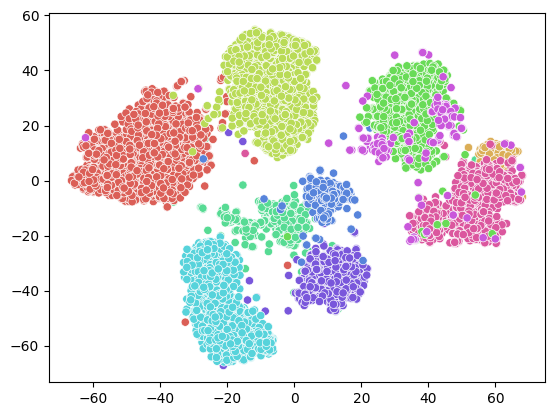

In [5]:

test_unseen_loc = np.squeeze(att_splits['test_unseen_loc']-1)
print(np.unique(test_unseen_loc), np.max(np.unique(test_unseen_loc))) # smallest location: 1046, largest location 35290

labels_test_unseen = labels[test_unseen_loc]
print('labels_test_unseen', labels_test_unseen, labels_test_unseen.shape)

unique_labels_test_unseen = np.unique(labels_test_unseen) # labels min:7 max:50
print('unique_labels_test_unseen', unique_labels_test_unseen, unique_labels_test_unseen.shape)# 10 classes


test_unseen_vec = X_features[:, test_unseen_loc].transpose()
print("Features for test unseen:", test_unseen_vec.shape) #(7913, 2048)


num_classes = 10

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(test_unseen_vec) 

print(z.shape)

df = pd.DataFrame()
df["y"] = np.reshape(labels_test_unseen, [labels_test_unseen.shape[0]])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", num_classes), data=df)
#plt.title('Original visual features')
plt.xlabel(None)
plt.ylabel(None)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.legend("", frameon=False)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 2048)]      0         
                                                                 
 layer1 (Conv2D)             (None, 1, 1, 2048)        4196352   
                                                                 
 layer2 (Conv2D)             (None, 1, 1, 1024)        2098176   
                                                                 
 layer3 (Conv2D)             (None, 1, 1, 1024)        1049600   
                                                                 
 layer4 (Conv2D)             (None, 1, 1, 2048)        2099200   
                                                                 
Total params: 9,443,328
Trainable params: 9,443,328
Non-trainable params: 0
_________________________________________________________________
(23527, 1, 1, 2048)
Model: "model_1"
______________

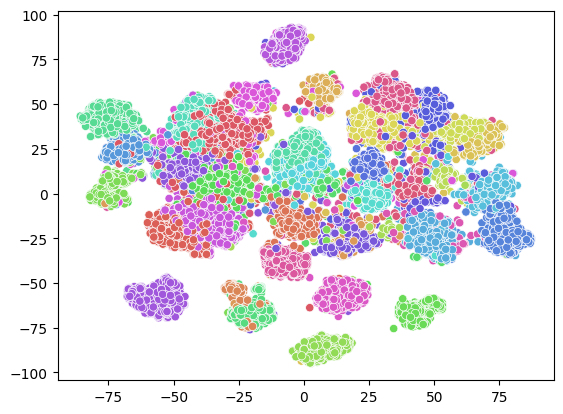

In [6]:
# embedding model
# -----------------------------------------------------------------------------------
inputt = Input(shape = (1, 1, trainval_vec.shape[1]))
hidden1 = Conv2D(2048, 1, name="layer1", activation='relu')(inputt)
output1 = Conv2D(1024, 1, name="layer2", activation='relu')(hidden1)
hidden2 = Conv2D(1024, 1, name="layer3", activation='relu')(output1)
output2 = Conv2D(2048, 1, name="layer4", activation='linear')(hidden2)

embedding_model = Model(inputs = inputt, outputs = output2)


adam = Adam(learning_rate = 0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0001)
embedding_model.compile(adam, loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.AUTO), metrics = ['accuracy'])
embedding_model.summary()


save_path = 'C:/Users/Admin/Sushree_Codes/Sush_3/Results/AWA2/BertAttribute/with_LE/Embedding Model/'
name = 'embedding_model_Bert2_2048_1024_1024_AWA2_200eph_adam_cos_16bch_0.0001lr'

file_path = save_path + 'bw_' + name + '.h5'

embedding_model.load_weights(save_path + 'bw_' + name + '.h5')

trainval_input1 = np.reshape(trainval_vec, [trainval_vec.shape[0], 1, 1, trainval_vec.shape[1]])
print(trainval_input1.shape)

embedding_model_0 = Model(inputs = embedding_model.input, outputs = embedding_model.layers[-3].output) # for embedding model
embedding_model_0.summary()

trainval_vec = embedding_model_0.predict(trainval_input1)
print(trainval_vec, trainval_vec.shape)

trainval_vec = reshape(trainval_vec, [trainval_vec.shape[0], trainval_vec.shape[1]*trainval_vec.shape[2]*trainval_vec.shape[3]])

num_classes = 40

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(trainval_vec) 

print(z.shape)

df = pd.DataFrame()
df["y"] = np.reshape(labels_trainval, [labels_trainval.shape[0]])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", num_classes), data=df)
#plt.title('Latent embedded visual features')
plt.xlabel(None)
plt.ylabel(None)
plt.legend("", frameon=False)


(7913, 1, 1, 2048)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 2048)]      0         
                                                                 
 layer1 (Conv2D)             (None, 1, 1, 2048)        4196352   
                                                                 
 layer2 (Conv2D)             (None, 1, 1, 1024)        2098176   
                                                                 
Total params: 6,294,528
Trainable params: 6,294,528
Non-trainable params: 0
_________________________________________________________________
248/248 [==============================] - 0s 2ms/step
[[[[0.1091337  0.         1.4055086  ... 1.8484277  1.0827006
    0.20674756]]]


 [[[0.         0.         1.6041927  ... 1.8943123  1.8794024
    0.        ]]]


 [[[0.         0.61485803 0.39113408 ... 3.2476127  1.9182622
    0.0283704

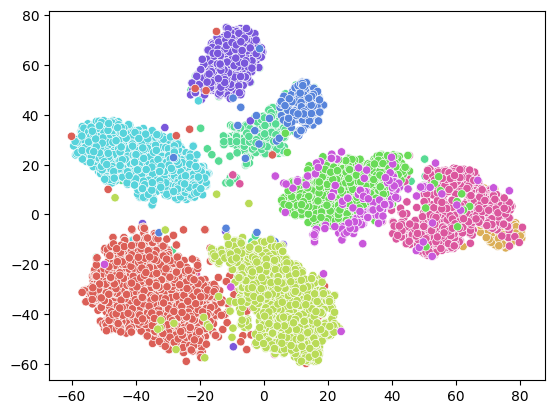

In [7]:
test_unseen_input1 = np.reshape(test_unseen_vec, [test_unseen_vec.shape[0], 1, 1, test_unseen_vec.shape[1]])
print(test_unseen_input1.shape)

embedding_model_0 = Model(inputs = embedding_model.input, outputs = embedding_model.layers[-3].output) # for embedding model
embedding_model_0.summary()

test_unseen_vec = embedding_model_0.predict(test_unseen_input1)
print(test_unseen_vec, test_unseen_vec.shape)

test_unseen_vec = reshape(test_unseen_vec, [test_unseen_vec.shape[0], test_unseen_vec.shape[1]*test_unseen_vec.shape[2]*test_unseen_vec.shape[3]])

num_classes = 10

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(test_unseen_vec) 

print(z.shape)

df = pd.DataFrame()
df["y"] = np.reshape(labels_test_unseen, [labels_test_unseen.shape[0]])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", num_classes), data=df)
#plt.title('Latent embedded visual features')
plt.xlabel(None)
plt.ylabel(None)
plt.legend("", frameon=False)